In [1]:
from pathlib import Path
import os
import pandas as pd
import seaborn as sns

pd.set_option('display.max_colwidth', 20)   # JSON columns make things look weird in notebook without this

from datatype_recovery.models.dataset import load_dataset_from_path
from datatype_recovery.models.dataset.encoding import *
from datatype_recovery.models.dataset.balance import plot_dataset_balance

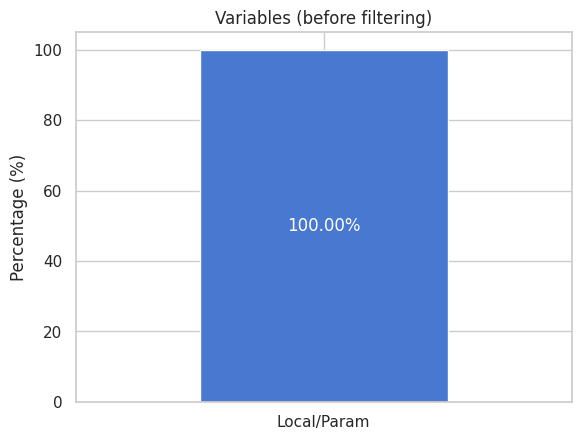

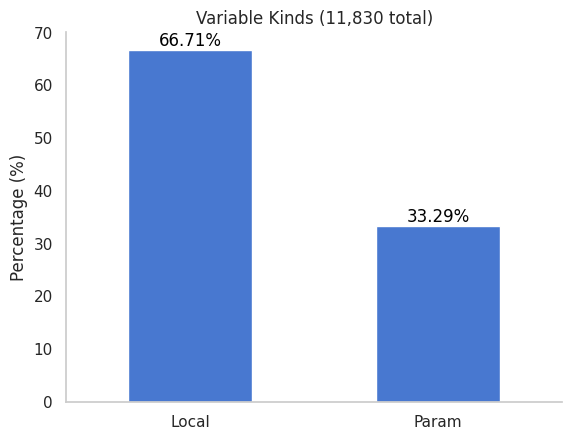

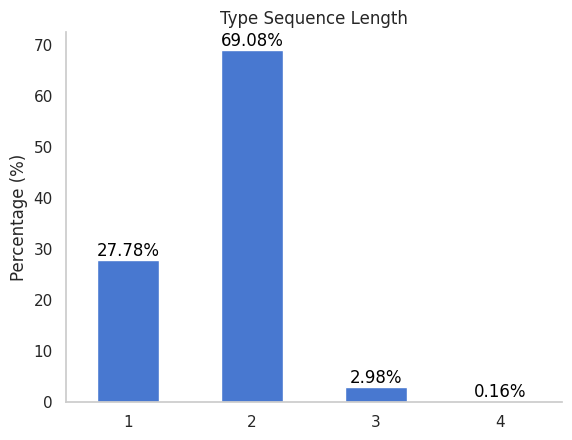

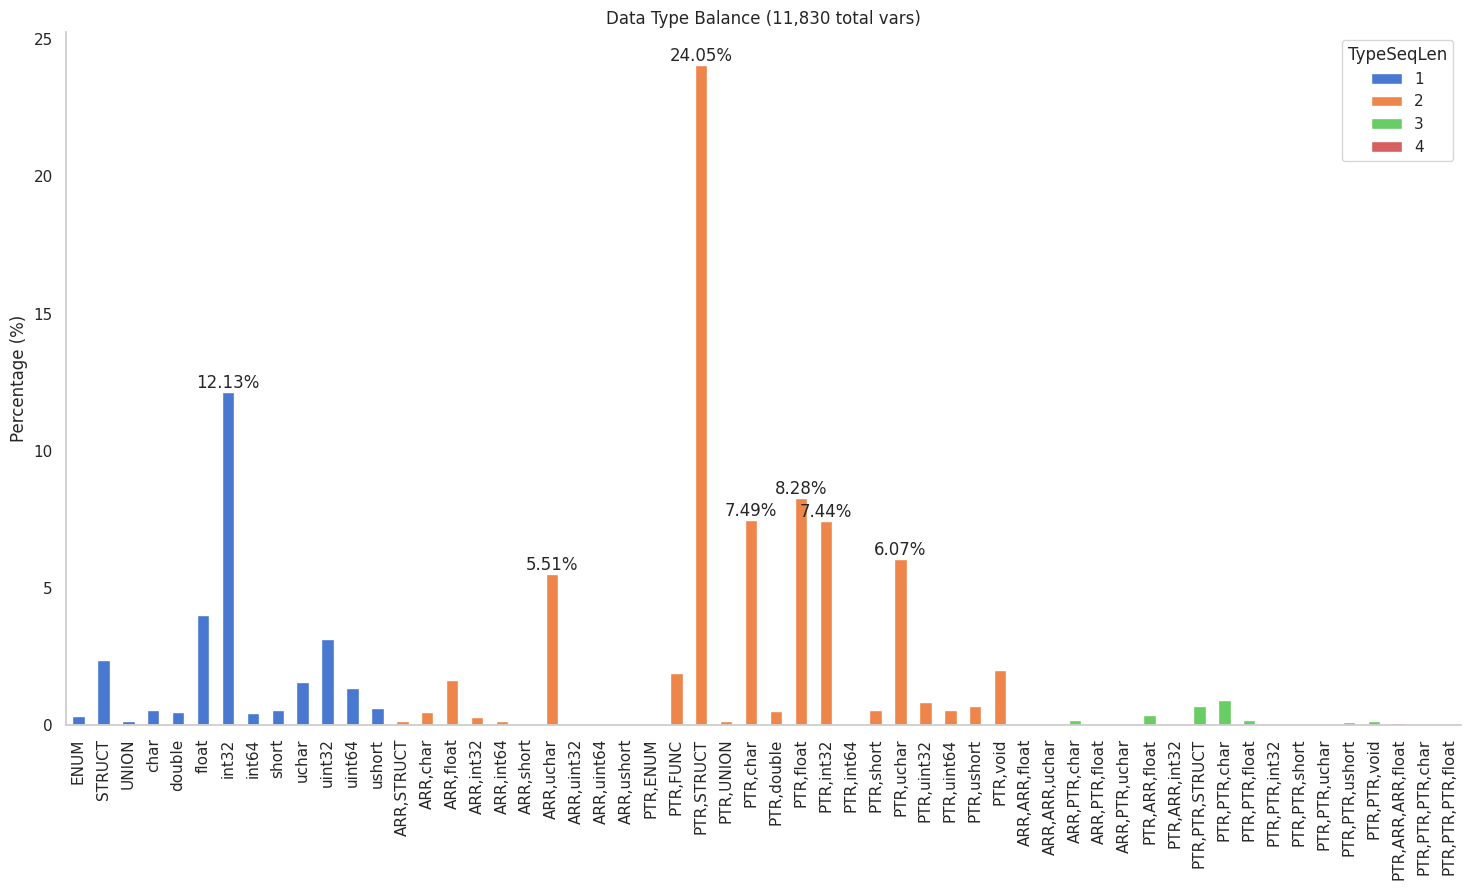

In [2]:
# ----------------------------------------------------------
# manual parameters
MANUAL_DATASET_PATH = Path.home()/'datasets/test_balance'
drop_comp = True
drop_return_types = True    # right now TypeSeqDatset is doing this
# ----------------------------------------------------------
# command-line parameters (take the env-var-specified params if present)
dataset_path = Path(os.environ['DATASET']) if 'DATASET' in os.environ else MANUAL_DATASET_PATH
# ----------------------------------------------------------


# context: talk, notebook, paper, poster
# palette: muted, Paired, hls, husl, pastel, bright, deep, dark, colorblind
sns.set_theme(style='whitegrid', context='notebook', palette='muted')

var_df, bal_df = plot_dataset_balance(dataset_path, drop_comp, drop_return_types)

In [3]:
var_df['LeafType'] = var_df.TypeSeq_Debug.apply(lambda x: x.split(',')[-1])
var_df['NumRefs'] = var_df.Signature.apply(lambda sig: len(sig.split(',')))

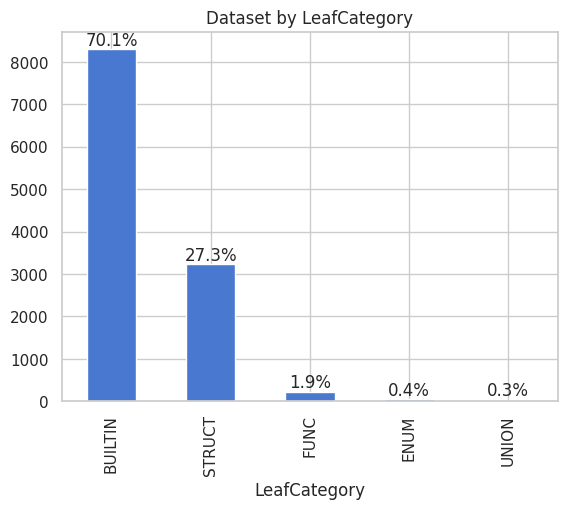

In [4]:
total_by_lcat = var_df.groupby('LeafCategory').count()[['FunctionStart']].rename({'FunctionStart':'Total'},axis=1)
ax = total_by_lcat.Total.sort_values(ascending=False).plot(kind='bar', title='Dataset by LeafCategory')

for container in ax.containers:
    ax.bar_label(container, fmt=lambda x: f'{x/len(var_df)*100:.1f}%')#, label_type='center')

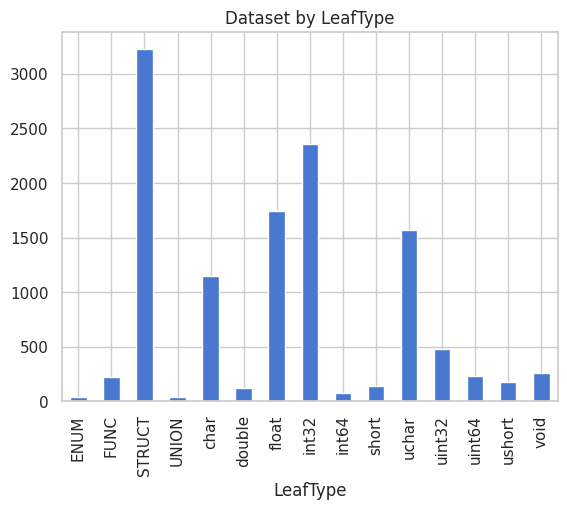

In [7]:
ax = var_df.groupby('LeafType').count().FunctionStart.plot(kind='bar',title='Dataset by LeafType')

# for container in ax.containers:
#     ax.bar_label(container, fmt=lambda x: f'{x/len(var_df)*100:.0f}%')

<Axes: title={'center': 'Pointer Levels'}, xlabel='PtrLevels'>

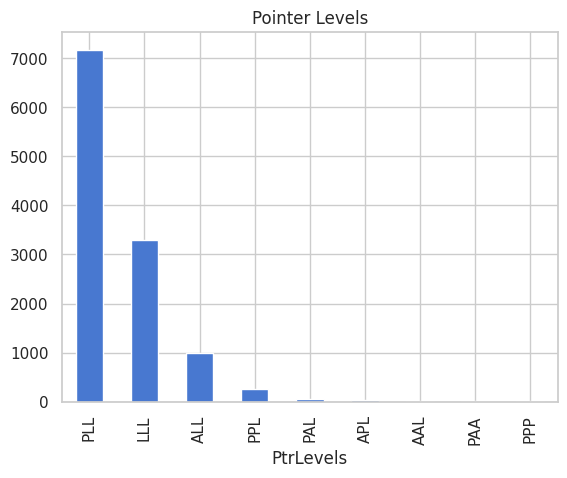

In [27]:
var_df.groupby('PtrLevels').count().FunctionStart.sort_values(ascending=False).plot(
    kind='bar', title='Pointer Levels'
)

<Axes: xlabel='PtrL1'>

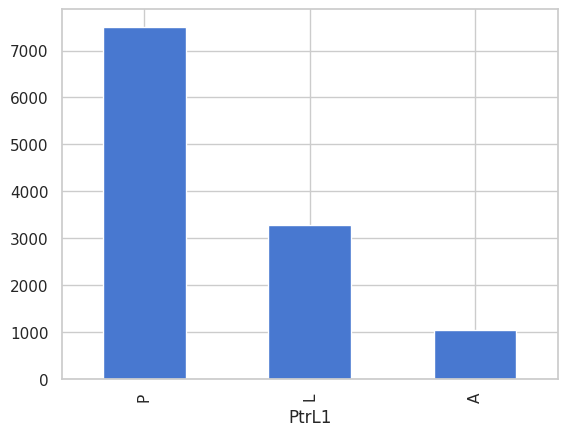

In [39]:
var_df.groupby('PtrL1').count().FunctionStart.sort_values(ascending=False).plot(kind='bar')

<Axes: title={'center': 'Variables by # References'}, xlabel='NumRefs'>

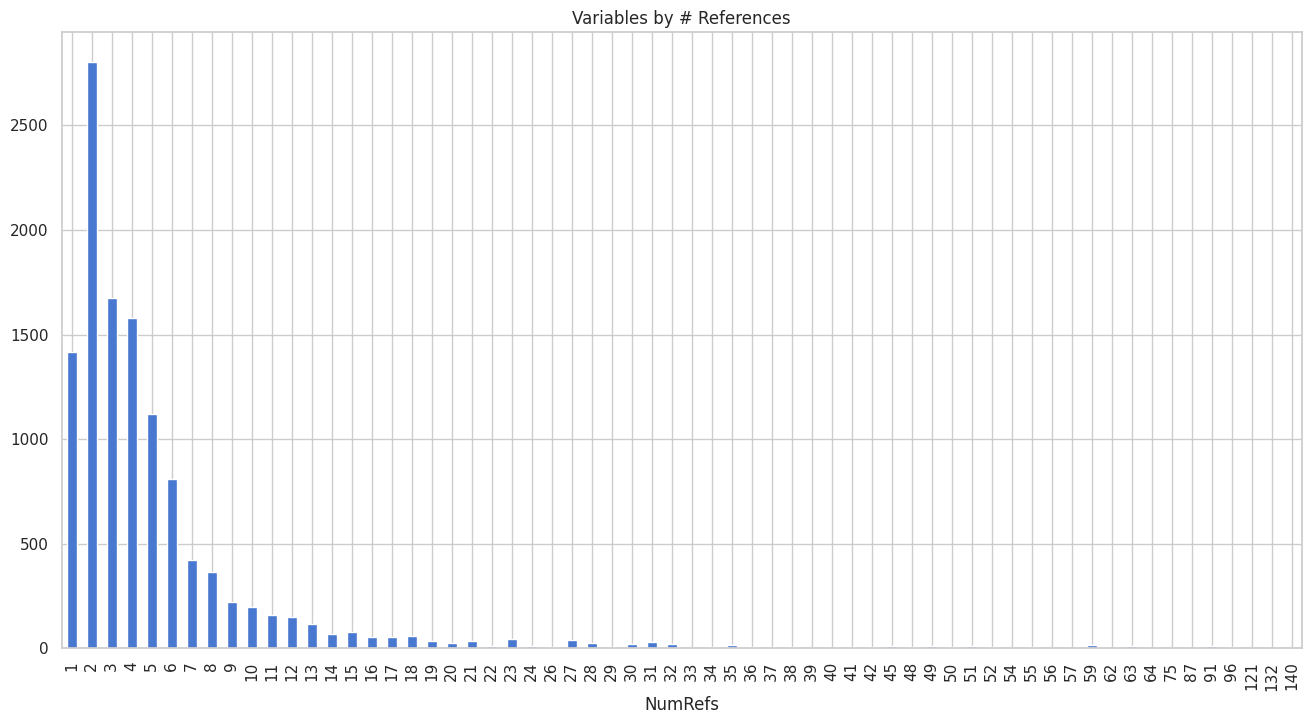

In [15]:
var_df.groupby('NumRefs').count().FunctionStart.plot(
    title='Variables by # References',
    kind='bar', figsize=(16,8), #ylim=(0, 500)
)